# 2c - COMPLEX - T+W

In [1]:
model_name = "ComplEx-T+W"

In [2]:
import random
import pickle
import os
import math
import csv
import datetime
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
from functions import AMLDataPreprocessing
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


![Screenshot 2024-05-23 at 21.28.02.png](<attachment:Screenshot 2024-05-23 at 21.28.02.png>)
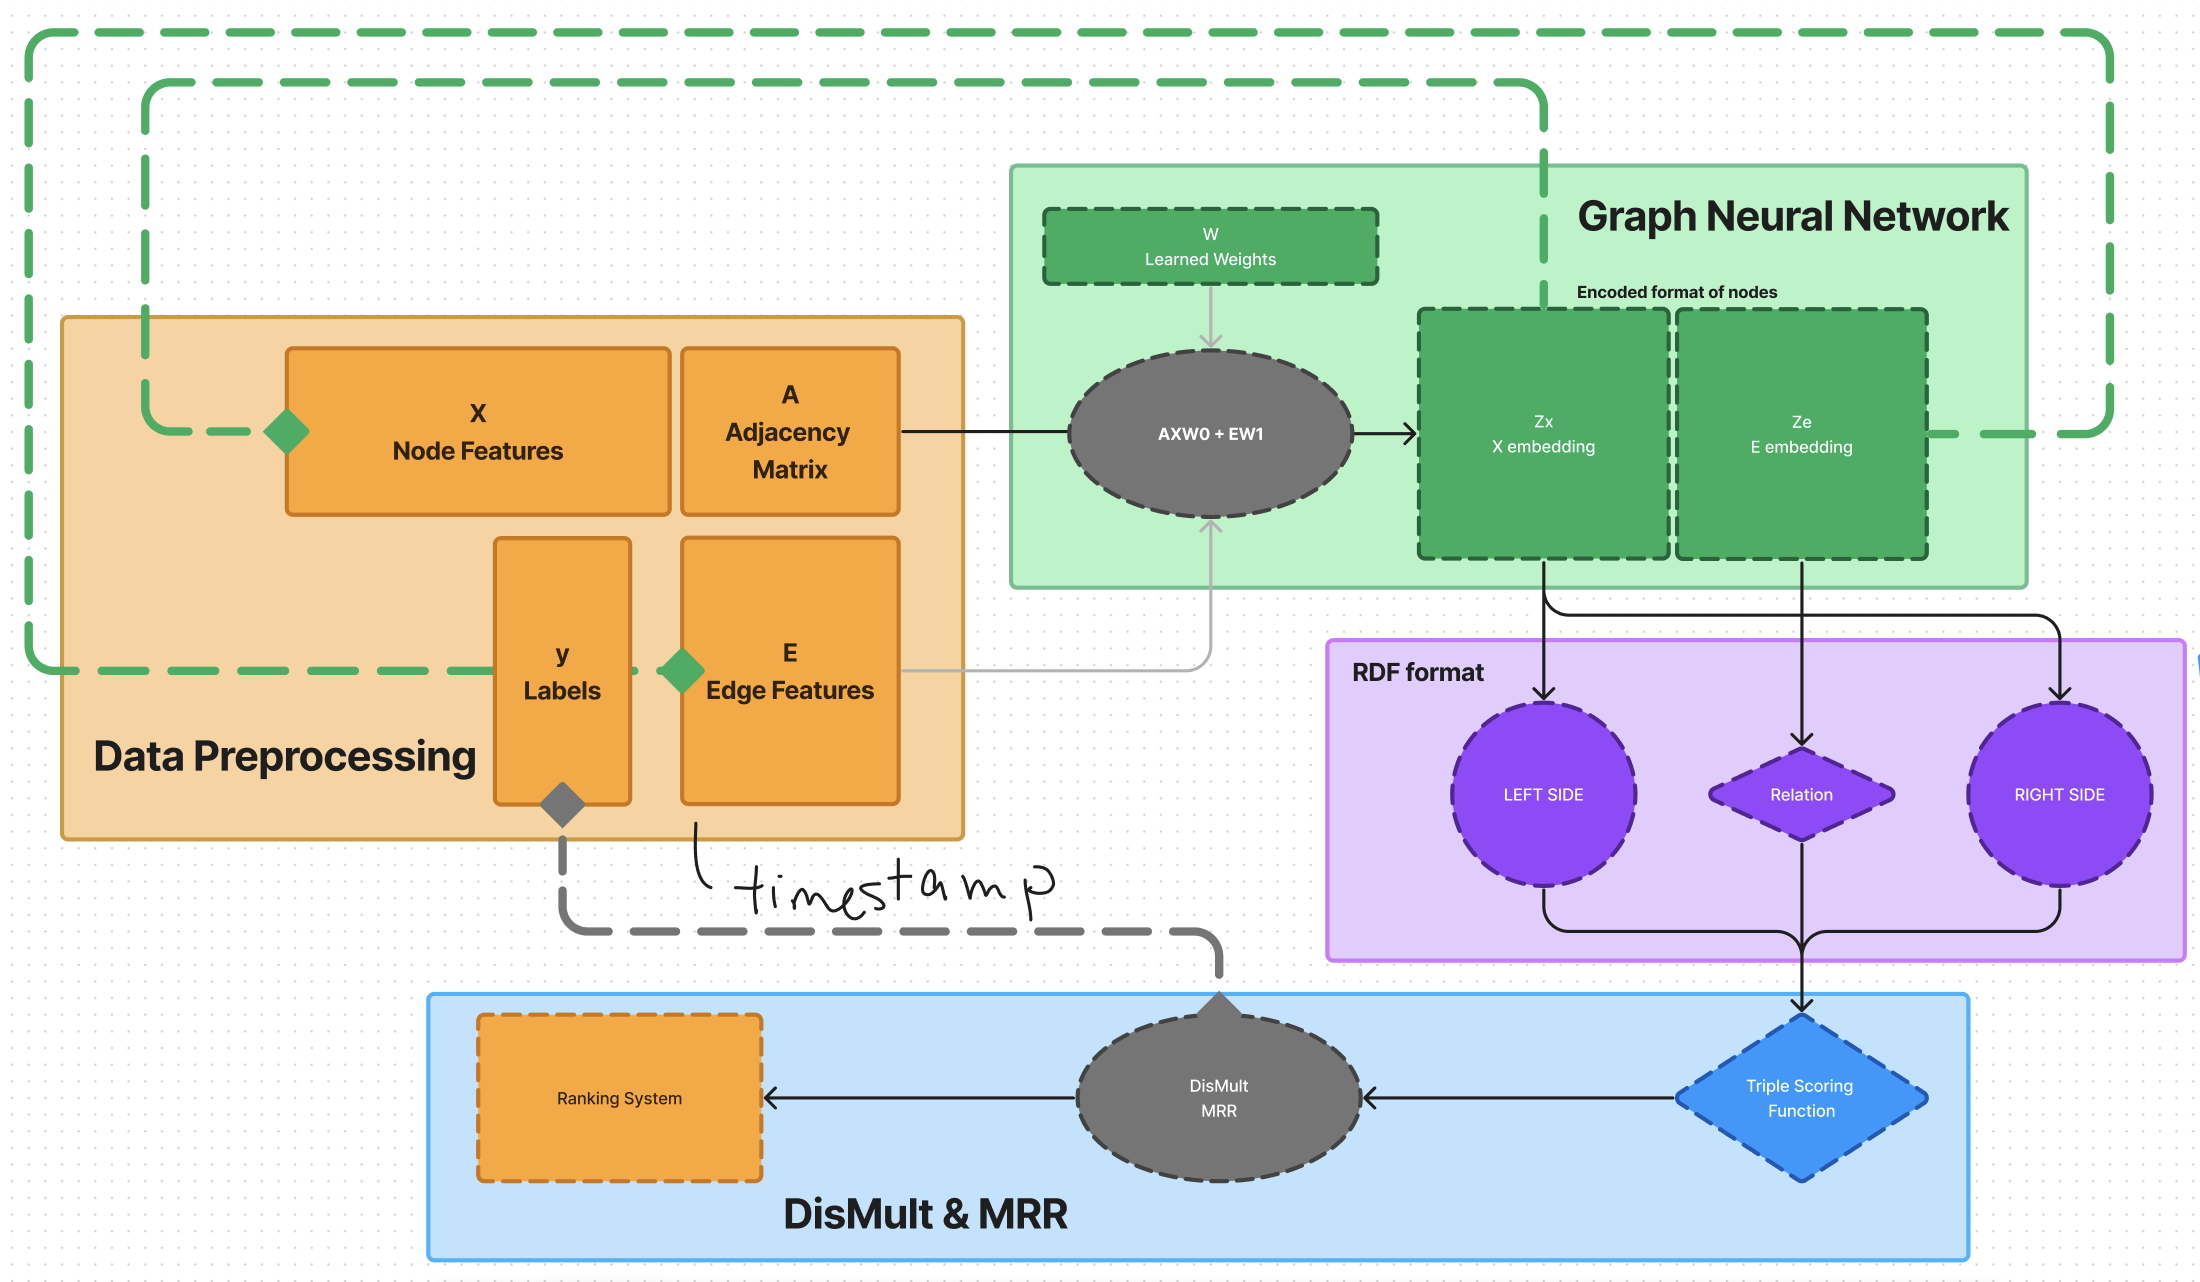

# LOADING GRAPH from Jupyter Notebook 
\(only use if not using Class Preprocessor)

In [3]:
import pickle

# Specify the file path where the data is saved
file_path = "Saved-Data/graph.pickle"

# Load the data from the file
with open(file_path, "rb") as f:
    saved_data = pickle.load(f)

# Now, you can access the saved data using the keys used during saving
dataset = saved_data['dataset']
edges_features = saved_data['edges_features']
links = saved_data['links']
labels = saved_data['labels']
graph_full = saved_data['graph_full']
adjacency_matrix = saved_data['adjacency_matrix']
visual = saved_data['visual']
node_features = saved_data['node_features']
x = saved_data['x']
y = saved_data['y']
input_data = saved_data['input_data']
time_closeness = saved_data['time_closeness']

In [4]:
edges_features

tensor([[4.7699e-04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [7.7419e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.4186e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.1475e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.1380e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.5062e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [5]:
input_data

Data(x=[15899, 44], edge_index=[2, 10000], edge_attr=[10000, 40], y=[10000])

In [6]:
input_data.edge_attr.size()

torch.Size([10000, 40])

In [7]:
labels.size()

torch.Size([10000])

In [8]:
input_data.x.size()

torch.Size([15899, 44])

In [9]:
node_features.size()

torch.Size([15899, 44])

In [10]:
adjacency_matrix.size()

torch.Size([15899, 15899])

In [11]:
# Split the nodes into training, validation, and test sets
num_edges = edges_features.shape[0]
indices = list(range(num_edges))
print(indices)
train_indices, test_val_indices = train_test_split(indices, test_size=0.4, stratify=labels)
val_indices, test_indices = train_test_split(test_val_indices, test_size=0.5, stratify=labels[test_val_indices])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [12]:
# Create masks
train_mask = torch.tensor([i in train_indices for i in range(num_edges)], dtype=torch.bool)
val_mask = torch.tensor([i in val_indices for i in range(num_edges)], dtype=torch.bool)
test_mask = torch.tensor([i in test_indices for i in range(num_edges)], dtype=torch.bool)

In [13]:
val_mask

tensor([ True,  True, False,  ..., False, False, False])

# GRAPH NEURAL NETWORKS

In [14]:
class GNNLayer(MessagePassing):
    def __init__(self, node_features, edge_features, out_channels, dropout):
        super(GNNLayer, self).__init__(aggr='add')
        self.node_features = node_features
        self.edge_features = edge_features
        self.out_channels = out_channels
        self.dropout = nn.Dropout(dropout)
        
        # Learnable parameters
        self.weight_node = nn.Parameter(torch.Tensor(node_features, out_channels))
        self.weight_edge = nn.Parameter(torch.Tensor(edge_features, out_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_node)
        nn.init.xavier_uniform_(self.weight_edge)
        
    def forward(self, x, edge_index, edge_attr):
        # AXW0 + EW1
        global adjacency_matrix
        self.adjacency_matrix = adjacency_matrix
        
        axw = torch.matmul(self.adjacency_matrix, x) @ self.weight_node
        ew = torch.matmul(edge_attr, self.weight_edge)

        axw = self.dropout(axw)  # Apply dropout to node features
        ew = self.dropout(ew)    # Apply dropout to edge features

        return axw, ew

    def update(self, aggr_out):
        return aggr_out

In [15]:
class GNNModel(nn.Module):
    def __init__(self, node_features, edge_features, out_channels, dropout):
        super(GNNModel, self).__init__()
        self.conv1 = GNNLayer(node_features, edge_features, out_channels, dropout)

        # Learnable parameters
        self.learnable_weight = nn.Parameter(torch.Tensor(1))
        print(self.learnable_weight.size())
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.uniform_(self.learnable_weight, a=0, b=1) 
    
    def forward(self, x, edge_index, edge_attr):
        axw1, ew1 = self.conv1(x, edge_index, edge_attr)

        head_indices, tail_indices = self.mapping(ew1, edge_index)
        # scores = self.dismult(axw1, ew1, head_indices, tail_indices)
        scores = self.complex(axw1, ew1, head_indices, tail_indices, time_closeness) # add the timestamp
        
        return axw1, ew1, scores # returning x and e embeddings

    def update_edge_attr(self, edge_attr, new_channels):
        num_edge_features = edge_attr.size(1)
        if new_channels > num_edge_features:
            updated_edge_attr = torch.cat((edge_attr, torch.zeros((edge_attr.size(0), new_channels - num_edge_features), device=edge_attr.device)), dim=1)
        else:
            updated_edge_attr = edge_attr[:, :new_channels]
        return updated_edge_attr
    
    def dismult(self, axw, ew, head_indices, tail_indices, time_closeness):
        scores = []
        heads = []
        tails = []
        relations = []
        for i in range(ew.size()[0]): # going through all triples
            head = axw[head_indices[i]]
            tail = axw[tail_indices[i]]
            relation = ew[i]
            heads.append(head)
            tails.append(tail)
            relations.append(relation)
            raw_score = torch.sum(head * relation * tail, dim=-1)
            # print(raw_score)
            normalized_score = torch.sigmoid(raw_score)  # Apply sigmoid activation
            scores.append(raw_score) # calc scores
        scores = torch.stack(scores)
        return scores

    def complex(self, axw, ew, head_indices, tail_indices, time_closeness):
        scores = []
        heads = []
        tails = []
        relations = []
        for i in range(ew.size()[0]): # going through all triples
            t = time_closeness[i]
            head = axw[head_indices[i]]
            tail = axw[tail_indices[i]]
            
            relation = ew[i]
            heads.append(head)
            tails.append(tail)
            relations.append(relation)
            # ComplEx
            # print(self.learnable_weight.size())
            # print(t)
            # print(self.learnable_weight[0])
            raw_score = torch.real(torch.sum(head * relation * torch.conj(tail), dim=0)) * (t * self.learnable_weight[0]) # TODO add a learnable element to the function for better performance 
            
            normalized_score = torch.sigmoid(raw_score)  # Apply sigmoid activation
            scores.append(raw_score) # calc scores
        scores = torch.stack(scores)
        return scores
    
    def mapping(self, ew, edge_index):
        head_indices = []
        tail_indices = []
        for c in range(ew.size()[0]): # getting all indices
            head_index = edge_index[0][c]
            tail_index = edge_index[1][c]
            head_indices.append(head_index)
            tail_indices.append(tail_index)
        
        return head_indices, tail_indices

In [16]:
# Hyperparams
learning_rate = 0.01
out_channels = 15
weight_decay = 5e-4  # L2 regularization factor
epochs = 100
dropout = 0.1 # dropout probability

# Annealing parameters
annealing_rate = 0.001  # Rate at which to decrease the learning rate
annealing_epochs = 10  # Number of epochs before decreasing learning rate

model = GNNModel(node_features=input_data.x.size(1), edge_features=input_data.edge_attr.size(1), out_channels=out_channels, dropout=dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss

torch.Size([1])


In [17]:
def train(data):
    model.train()
    optimizer.zero_grad()
    x_embedding, e_embedding, scores = model(data.x, data.edge_index[:, train_mask], data.edge_attr[train_mask])

    loss = criterion(scores, labels[train_mask].float())
    loss.backward()
    optimizer.step()
    
    return loss.item(), x_embedding, e_embedding, scores

# Validation function
def validate(data):
    model.eval()
    with torch.no_grad():
        x_embedding, e_embedding, scores = model(data.x, data.edge_index[:, val_mask], data.edge_attr[val_mask])
        val_loss = criterion(scores, labels[val_mask].float()).item()
    return x_embedding, e_embedding, scores, val_loss

# Test function
def test(data):
    model.eval()
    with torch.no_grad():
        x_embedding, e_embedding, scores = model(data.x, data.edge_index[:, test_mask], data.edge_attr[test_mask])
        test_loss = criterion(scores, labels[test_mask].float()).item()
    return x_embedding, e_embedding, scores, test_loss

In [18]:
def assign_top_n_predictions(val_scores, val_labels):
    # Sort indices of val_scores in descending order
    sorted_indices = torch.argsort(val_scores, descending=True)

    # Determine the number of top predictions to assign as 1
    num_ones = int(torch.sum(val_labels).item())

    # Create a tensor to store the predicted labels (initialized with all zeros)
    predicted_labels = torch.zeros_like(val_labels)

    # Assign the top n predictions as 1
    predicted_labels[sorted_indices[:num_ones]] = 1

    return predicted_labels, sorted_indices

In [19]:
def assign_predictions(val_scores, threshold=0.5):
    # Assign labels based on a threshold
    predicted_labels = (val_scores >= threshold).float()
    return predicted_labels

In [20]:
def calculate_mrr(sorted_indices, true_values):
    # print("Calculating MRR...")
    rank = 0
    count = 0
    for i in range( len(true_values) ):
        if true_values[i] == 1: # should only be the positive ones --> 600
            count += 1
            for j in range( len(sorted_indices) ):
                if sorted_indices[j] == i:
                    # print(f"sorted indices: {sorted_indices[j]}")
                    # print(f"i: {i}")
                    position = j+1
                    # print(f"position: {position}")
                    break
            rank += 1/position
            # print(f"rank - individual: {rank}")
    # print(f"rank: {rank}")
    # print(f"n of true values: {count}")
    mrr = rank / count
    # print("MRR Calculated...")
    return mrr

In [21]:
# Continue training loop from provided script
losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10

all_x_embeddings = []
all_e_embeddings = []

# Storage for metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for epoch in range(epochs):
    # Adjust learning rate based on annealing schedule
    if epoch % annealing_epochs == 0 and epoch != 0:
        new_learning_rate = learning_rate * math.exp(-annealing_rate * epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_learning_rate
            
    loss, x_embedding, e_embedding, scores = train(input_data)
    val_x_embedding, val_e_embedding, val_scores, val_loss = validate(input_data)

    losses.append(loss)
    val_losses.append(val_loss)

    all_x_embeddings.append(x_embedding.detach().cpu().numpy())
    all_e_embeddings.append(e_embedding.detach().cpu().numpy())
    # print(f"This is Fraudulent - {scores[8000]}")
    # print(f"This is Not fraudulent - {scores[2000]}")

    val_labels = labels[val_mask]
    # predictions, sorted_indices = assign_top_n_predictions(val_scores, val_labels)
    predictions = assign_predictions(val_scores)
    sorted_indices = torch.argsort(val_scores, descending=True)

    # Calculate evaluation metrics
    accuracy = accuracy_score(val_labels, predictions)
    precision = precision_score(val_labels, predictions)
    recall = recall_score(val_labels, predictions)
    f1 = f1_score(val_labels, predictions)

    # Append metrics to respective lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"\nEpoch {epoch}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    if epoch % 10 == 0 and epoch != 0:
        # calculate MRR
        # mrr = calculate_mrr(sorted_indices, val_labels)
        mrr = calculate_mrr(sorted_indices, val_labels) # TODO MRR USING SORTED INDICES? WHY?
        print(f"This is the MRR for epoch {epoch}: {mrr}")
    # EARLY STOPPING CHECK 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model if validation loss improves
        torch.save(model.state_dict(), f'Saved-Data/{model_name}.pt')
    else:
        patience_counter += 1
        if patience_counter > patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Early stopping...")
            break


Epoch 0, Training Loss: 0.6776, Validation Loss: 0.6587
Accuracy: 0.7010, Precision: 0.5333, Recall: 0.0267, F1 Score: 0.0508

Epoch 1, Training Loss: 0.6495, Validation Loss: 0.6400
Accuracy: 0.7050, Precision: 0.6316, Recall: 0.0400, F1 Score: 0.0752

Epoch 2, Training Loss: 0.6420, Validation Loss: 0.6249
Accuracy: 0.7090, Precision: 0.7368, Recall: 0.0467, F1 Score: 0.0878

Epoch 3, Training Loss: 0.6268, Validation Loss: 0.6110
Accuracy: 0.7125, Precision: 0.7778, Recall: 0.0583, F1 Score: 0.1085

Epoch 4, Training Loss: 0.6053, Validation Loss: 0.5965
Accuracy: 0.7200, Precision: 0.8030, Recall: 0.0883, F1 Score: 0.1592

Epoch 5, Training Loss: 0.5970, Validation Loss: 0.5824
Accuracy: 0.7285, Precision: 0.8065, Recall: 0.1250, F1 Score: 0.2165

Epoch 6, Training Loss: 0.5788, Validation Loss: 0.5696
Accuracy: 0.7365, Precision: 0.7829, Recall: 0.1683, F1 Score: 0.2771

Epoch 7, Training Loss: 0.5662, Validation Loss: 0.5581
Accuracy: 0.7510, Precision: 0.7931, Recall: 0.2300, F

In [22]:
val_scores.size()

torch.Size([2000])

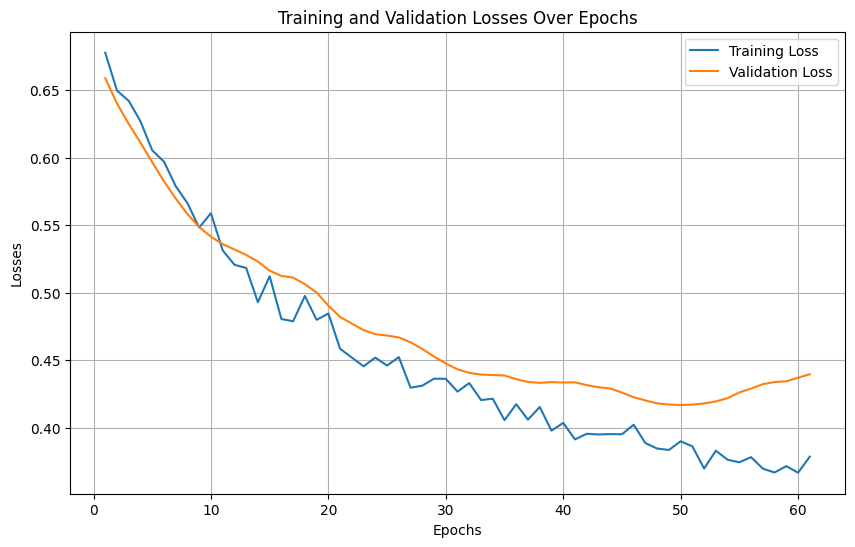

In [23]:
# Plot
epoch_numbers = list(range(1, len(losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, losses, label="Training Loss")
plt.plot(epoch_numbers, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

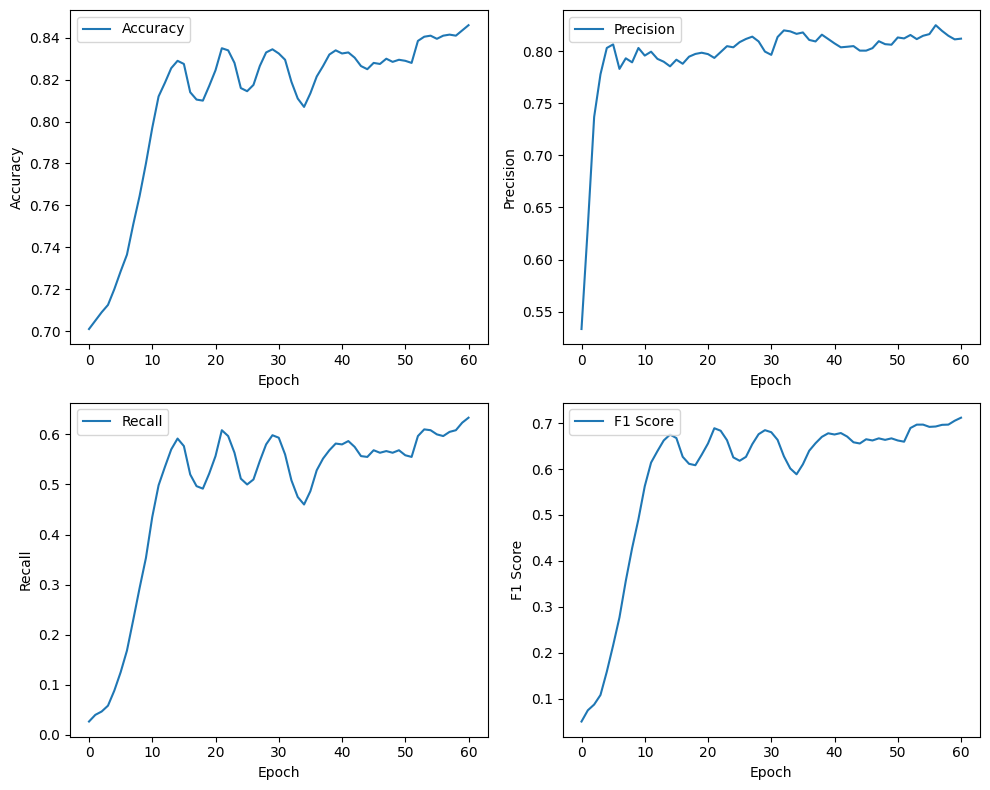

In [24]:
plt.figure(figsize=(10, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 2, 2)
plt.plot(precision_list, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 3)
plt.plot(recall_list, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(f1_list, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
def evaluate_model(predictions, true_values, sorted_indices, mask):

    true_values = true_values[mask].float()
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    true_values = true_values.cpu().numpy()
    
    mrr = calculate_mrr(sorted_indices, true_values) # TODO --> this is just the accuracy now ... 
    print(f"MRR = {mrr}")
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(true_values, predictions)
    precision = precision_score(true_values, predictions)
    recall = recall_score(true_values, predictions)
    f1 = f1_score(true_values, predictions)
    cm = confusion_matrix(true_values, predictions)
    classification_rep = classification_report(true_values, predictions)
    
    # ROC Curve and AUC if applicable
    try:
        fpr, tpr, thresholds = roc_curve(true_values, predictions)
        roc_auc = auc(fpr, tpr)
    except ValueError:
        fpr, tpr, roc_auc = None, None, None
    
    metrics_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm,
        "Classification Report": classification_rep,
        "ROC Curve": (fpr, tpr, roc_auc)
    }

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

MRR = 0.010435755187420915


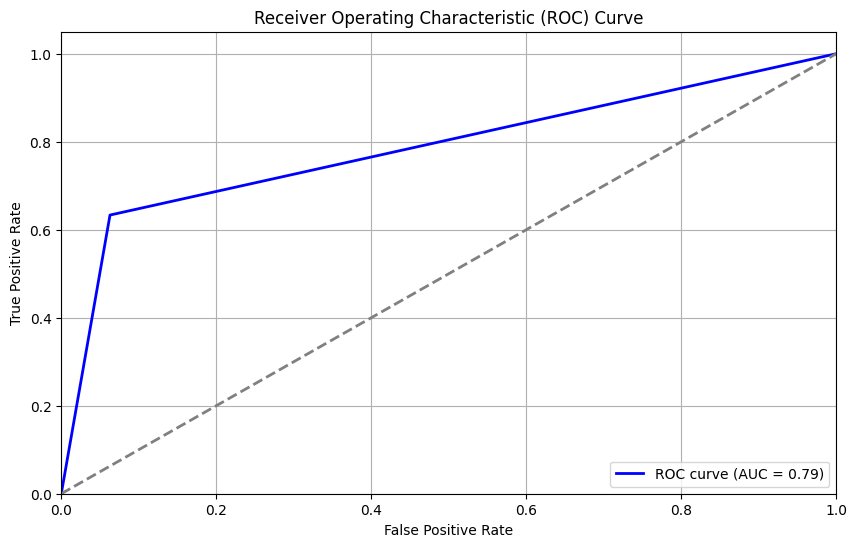

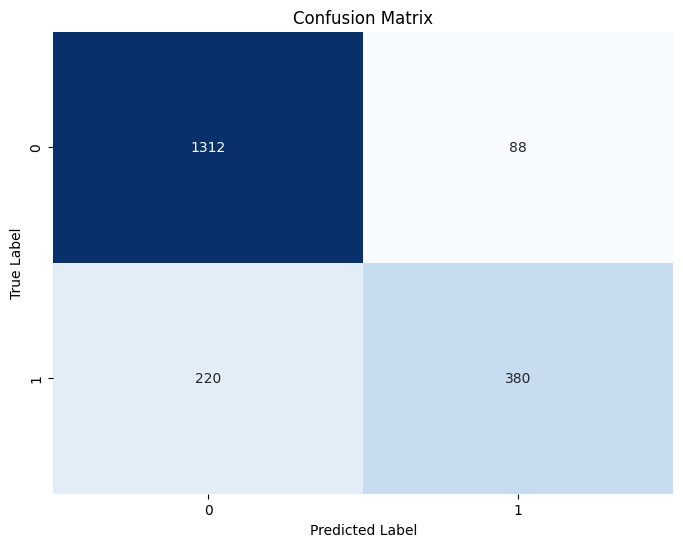

Evaluation Metrics:
-------------------

Accuracy: 0.846

Precision: 0.811965811965812

Recall: 0.6333333333333333

F1 Score: 0.7116104868913857

Confusion Matrix:
[[1312   88]
 [ 220  380]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.89      1400
         1.0       0.81      0.63      0.71       600

    accuracy                           0.85      2000
   macro avg       0.83      0.79      0.80      2000
weighted avg       0.84      0.85      0.84      2000


ROC Curve:
- False Positive Rate: [0.         0.06285714 1.        ]
- True Positive Rate: [0.         0.63333333 1.        ]
- AUC: 0.7852380952380952



In [26]:
metrics_dict = evaluate_model(predictions, labels, sorted_indices, val_mask)

# Print Evaluation Metrics
print("Evaluation Metrics:")
print("-------------------\n")
for metric_name, metric_value in metrics_dict.items():
    if metric_name == "Confusion Matrix":
        print("Confusion Matrix:")
        print(metric_value)
    elif metric_name == "Classification Report":
        print("Classification Report:")
        print(metric_value)
    elif metric_name == "ROC Curve":
        fpr, tpr, roc_auc = metric_value
        print("ROC Curve:")
        print("- False Positive Rate:", fpr)
        print("- True Positive Rate:", tpr)
        print("- AUC:", roc_auc)
    else:
        print(f"{metric_name}: {metric_value}")
    print()

# TEST DATA

In [27]:
test_x_embedding, test_e_embedding, test_scores, test_loss = test(input_data)

In [28]:
print(f"Test Loss: {test_loss:.4f}")

test_labels = labels[test_mask]
test_predictions = assign_predictions(test_scores)

sorted_indices = torch.argsort(test_scores, descending=True)

# Calculate evaluation metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

test_mrr = calculate_mrr(sorted_indices, test_labels)

print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")
print(f"This is the MRR testing data: {test_mrr}")

Test Loss: 0.4390
Accuracy: 0.8585, Precision: 0.8323, Recall: 0.6617, F1 Score: 0.7372
This is the MRR testing data: 0.010033440486928573


MRR = 0.010033440486928573


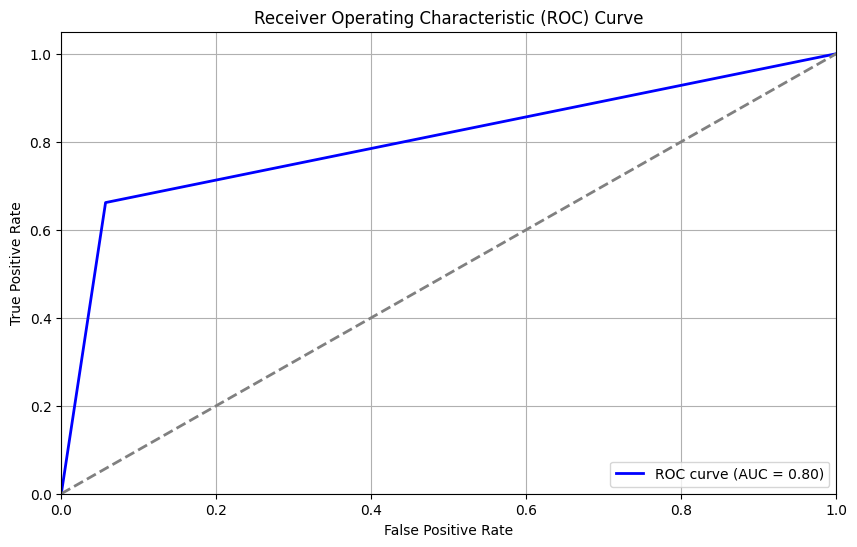

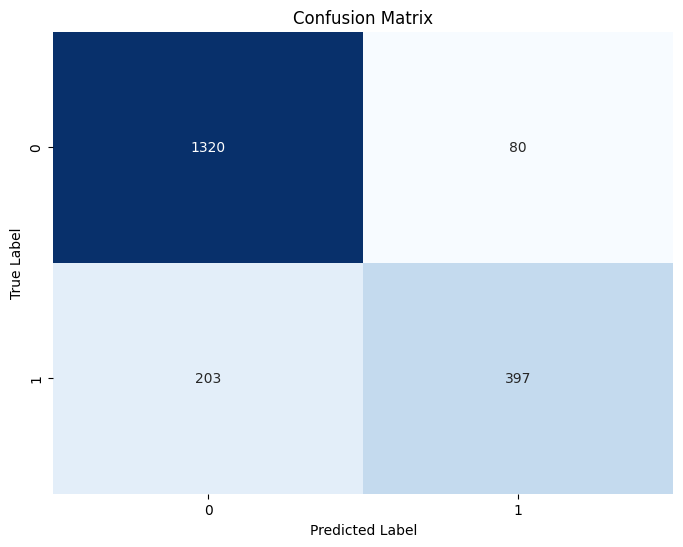

Evaluation Metrics:
-------------------

Accuracy: 0.8585

Precision: 0.8322851153039832

Recall: 0.6616666666666666

F1 Score: 0.7372330547818013

Confusion Matrix:
[[1320   80]
 [ 203  397]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      1400
         1.0       0.83      0.66      0.74       600

    accuracy                           0.86      2000
   macro avg       0.85      0.80      0.82      2000
weighted avg       0.86      0.86      0.85      2000


ROC Curve:
- False Positive Rate: [0.         0.05714286 1.        ]
- True Positive Rate: [0.         0.66166667 1.        ]
- AUC: 0.8022619047619047



In [29]:
metrics_dict = evaluate_model(test_predictions, labels, sorted_indices, test_mask)

# Print Evaluation Metrics
print("Evaluation Metrics:")
print("-------------------\n")
for metric_name, metric_value in metrics_dict.items():
    if metric_name == "Confusion Matrix":
        print("Confusion Matrix:")
        print(metric_value)
    elif metric_name == "Classification Report":
        print("Classification Report:")
        print(metric_value)
    elif metric_name == "ROC Curve":
        fpr, tpr, roc_auc = metric_value
        print("ROC Curve:")
        print("- False Positive Rate:", fpr)
        print("- True Positive Rate:", tpr)
        print("- AUC:", roc_auc)
    else:
        print(f"{metric_name}: {metric_value}")
    print()

## LOGGING

In [30]:
# Function to log the experiment
def log_experiment(model_name, learning_rate, out_channels, epoch, weight_decay, dropout, loss, accuracy, precision, recall, f1, mrr, roc_auc):
    # Create a folder for the experiment if it doesn't exist
    folder_name = f"Results/{model_name}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Save metrics and other information to a file
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    file_name = f"{folder_name}/run_{timestamp}.txt"
    with open(file_name, "w") as f:
        f.write(f"-- HYPERPARAMS:\n")
        f.write(f"TimeStamp: {timestamp}\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"learning_rate: {learning_rate}\n")
        f.write(f"out_channels: {out_channels}\n")
        f.write(f"Epoch: {epoch}\n\n")
        f.write(f"Weight_decay: {weight_decay}\n\n")
        f.write(f"Dropout: {dropout}\n\n")
        f.write(f"-- RESULTS:\n")
        f.write(f"Loss: {loss}\n")
        f.write(f"Accuracy: {accuracy}\n")
        f.write(f"Precision: {precision}\n")
        f.write(f"Recall: {recall}\n")
        f.write(f"F1 Score: {f1}\n")
        f.write(f"MRR: {mrr}\n")
        f.write(f"AUC: {roc_auc}\n")
    
    # Update the general CSV file
    csv_file = f"Results/general.csv"
    write_header = not os.path.exists(csv_file)
    with open(csv_file, "a") as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow(["Model", "Timestamp", "learning_rate", "out_channels", "Epoch", "Weight_decay", "Dropout", "Loss", "Accuracy", "Precision", "Recall", "F1 Score", "MRR", "AUC"])
        writer.writerow([model_name, timestamp,  learning_rate, out_channels, epoch, weight_decay, dropout, loss, accuracy, precision, recall, f1, mrr, roc_auc])

# Inside the training loop, after each epoch:
# Log the experiment
log_experiment(model_name=model_name, learning_rate=learning_rate, out_channels=out_channels, epoch=epoch, weight_decay=weight_decay, dropout=dropout, loss=test_loss, accuracy=test_accuracy, precision=test_precision, recall=test_recall, f1=test_f1, mrr=test_mrr, roc_auc=roc_auc)

# PYTORCH.save --> save the tensor for predictions for the graph
torch.save({'test_labels': test_labels}, f'labels.pt')
torch.save({'predictions': test_predictions}, f'predictions_{model_name}_{random.randint(1, 100)}.pt')

# Save in RDF format

In [31]:
import gzip
import torch

def save_embeddings_as_triples(edge_index, node_embeddings, edge_embeddings, file_path):
    with gzip.open(file_path, 'wt') as f:
        for i in range(edge_index.size(1)):
            head_index = edge_index[0, i].item()
            tail_index = edge_index[1, i].item()
            head_uri = f"http://example.org/node/{head_index}"
            tail_uri = f"http://example.org/node/{tail_index}"
            relation_uri = f"http://example.org/relation/{i}"

            # Write connectedTo triple
            f.write(f'<{head_uri}> <http://example.org/ontology#connectedTo> <{tail_uri}>.\n')
            
            # Write head node embedding triple
            head_embedding = node_embeddings[head_index].numpy()
            head_str = ' '.join(map(str, head_embedding))
            f.write(f'<{head_uri}> <http://example.org/ontology#hasEmbedding> "{head_str}."\n')
            
            # Write tail node embedding triple
            tail_embedding = node_embeddings[tail_index].numpy()
            tail_str = ' '.join(map(str, tail_embedding))
            f.write(f'<{tail_uri}> <http://example.org/ontology#hasEmbedding> "{tail_str}".\n')
            
            # Write edge embedding triple
            relation_embedding = edge_embeddings[i].numpy()
            relation_str = ' '.join(map(str, relation_embedding))
            f.write(f'<{relation_uri}> <http://example.org/ontology#hasEmbedding> "{relation_str}".\n')

edge_index_train_triples = input_data.edge_index[:, train_mask]

# Example usage after training
x_embeddings = torch.tensor(all_x_embeddings[-1])  # Use the last epoch's embeddings
e_embeddings = torch.tensor(all_e_embeddings[-1])  # Use the last epoch's embeddings

save_embeddings_as_triples(edge_index_train_triples, x_embeddings, e_embeddings, f"Saved-Data/rdf_triples_{model_name}.nt.gz")
